In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable, Type
import abc

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
from torch import Tensor

In [9]:
import torch
import matplotlib.pyplot as plt
import time

# Check if GPU is available
device_cpu = torch.device('cpu')
device_gpu = torch.device('cuda') if torch.cuda.is_available() else None

# Define ranges for N and D
N_values = [100, 1_000, 10_000, 100_000]
D_values = [32, 64, 128, 256, 512]

# Fixed D for varying N
D_fixed = 512

# Fixed N for varying D
N_fixed = 5000

# Function to time the three approaches
def time_decompositions(X, device):
    times = {}
    X = X.to(device)
    
    # Approach 1: SVD of X
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()
    torch.linalg.svd(X, full_matrices=False)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    times['svd_X'] = time.time() - start_time
    
    # Approach 2: QR of X
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()
    torch.linalg.qr(X, mode='reduced')
    if device.type == 'cuda':
        torch.cuda.synchronize()
    times['qr_X'] = time.time() - start_time
    
    # Approach 3: Compute XᵗX and SVD of XᵗX
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()
    XTX = X.T @ X
    torch.linalg.svd(XTX, full_matrices=False)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    times['svd_XTX'] = time.time() - start_time
    
    # Approach 4: Compute XᵗX and QR of XᵗX
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()
    XTX = X.T @ X
    torch.linalg.qr(XTX)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    times['qr_XTX'] = time.time() - start_time
    
    # Approach 5: Compute XᵗX and eigh of XᵗX
    if device.type == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()
    XTX = X.T @ X
    torch.linalg.eigh(XTX)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    times['eigh_XTX'] = time.time() - start_time
    
    return times

# Update results dictionaries for varying N
results_cpu_N = {'N': [], 'svd_X': [], 'qr_X': [], 'svd_XTX': [], 'qr_XTX': [], 'eigh_XTX': []}
results_gpu_N = {'N': [], 'svd_X': [], 'qr_X': [], 'svd_XTX': [], 'qr_XTX': [], 'eigh_XTX': []} if device_gpu else None

# Update results dictionaries for varying D
results_cpu_D = {'D': [], 'svd_X': [], 'qr_X': [], 'svd_XTX': [], 'qr_XTX': [], 'eigh_XTX': []}
results_gpu_D = {'D': [], 'svd_X': [], 'qr_X': [], 'svd_XTX': [], 'qr_XTX': [], 'eigh_XTX': []} if device_gpu else None

# Vary N, fixed D
for N in N_values:
    X = torch.randn(N, D_fixed)
    
    # CPU timings
    times_cpu = time_decompositions(X, device_cpu)
    results_cpu_N['N'].append(N)
    results_cpu_N['svd_X'].append(times_cpu['svd_X'])
    results_cpu_N['qr_X'].append(times_cpu['qr_X'])
    results_cpu_N['svd_XTX'].append(times_cpu['svd_XTX'])
    results_cpu_N['qr_XTX'].append(times_cpu['qr_XTX'])
    results_cpu_N['eigh_XTX'].append(times_cpu['eigh_XTX'])
    
    # GPU timings
    if device_gpu:
        times_gpu = time_decompositions(X, device_gpu)
        results_gpu_N['N'].append(N)
        results_gpu_N['svd_X'].append(times_gpu['svd_X'])
        results_gpu_N['qr_X'].append(times_gpu['qr_X'])
        results_gpu_N['svd_XTX'].append(times_gpu['svd_XTX'])
        results_gpu_N['qr_XTX'].append(times_gpu['qr_XTX'])
        results_gpu_N['eigh_XTX'].append(times_gpu['eigh_XTX'])

# Vary D, fixed N
for D in D_values:
    X = torch.randn(N_fixed, D)
    
    # CPU timings
    times_cpu = time_decompositions(X, device_cpu)
    results_cpu_D['D'].append(D)
    results_cpu_D['svd_X'].append(times_cpu['svd_X'])
    results_cpu_D['qr_X'].append(times_cpu['qr_X'])
    results_cpu_D['svd_XTX'].append(times_cpu['svd_XTX'])
    results_cpu_D['qr_XTX'].append(times_cpu['qr_XTX'])
    results_cpu_D['eigh_XTX'].append(times_cpu['eigh_XTX'])
    
    # GPU timings
    if device_gpu:
        times_gpu = time_decompositions(X, device_gpu)
        results_gpu_D['D'].append(D)
        results_gpu_D['svd_X'].append(times_gpu['svd_X'])
        results_gpu_D['qr_X'].append(times_gpu['qr_X'])
        results_gpu_D['svd_XTX'].append(times_gpu['svd_XTX'])
        results_gpu_D['qr_XTX'].append(times_gpu['qr_XTX'])
        results_gpu_D['eigh_XTX'].append(times_gpu['eigh_XTX'])

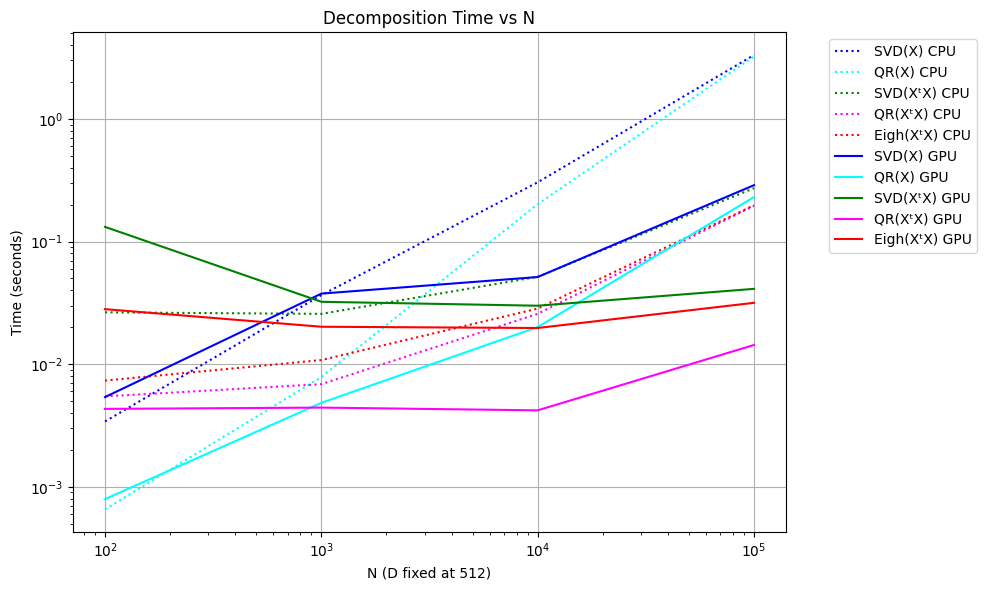

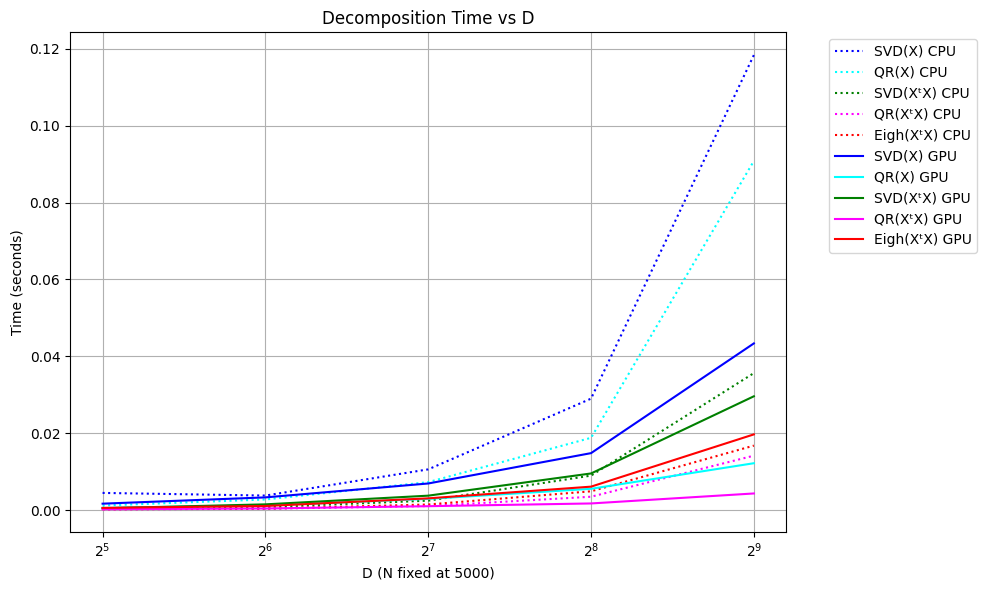

In [17]:
# Plot results for varying N
plt.figure(figsize=(10, 6))

# Define styles
line_styles = {'CPU': 'dotted', 'GPU': 'solid'}
colors = {
    'svd_X': 'blue', 
    'qr_X': 'cyan',
    'svd_XTX': 'green', 
    'qr_XTX': 'magenta',
    'eigh_XTX': 'red'
}

# Plot CPU results
plt.plot(results_cpu_N['N'], results_cpu_N['svd_X'], linestyle=line_styles['CPU'], color=colors['svd_X'], label='SVD(X) CPU')
plt.plot(results_cpu_N['N'], results_cpu_N['qr_X'], linestyle=line_styles['CPU'], color=colors['qr_X'], label='QR(X) CPU')
plt.plot(results_cpu_N['N'], results_cpu_N['svd_XTX'], linestyle=line_styles['CPU'], color=colors['svd_XTX'], label='SVD(XᵗX) CPU')
plt.plot(results_cpu_N['N'], results_cpu_N['qr_XTX'], linestyle=line_styles['CPU'], color=colors['qr_XTX'], label='QR(XᵗX) CPU')
plt.plot(results_cpu_N['N'], results_cpu_N['eigh_XTX'], linestyle=line_styles['CPU'], color=colors['eigh_XTX'], label='Eigh(XᵗX) CPU')

# Plot GPU results
if device_gpu:
    plt.plot(results_gpu_N['N'], results_gpu_N['svd_X'], linestyle=line_styles['GPU'], color=colors['svd_X'], label='SVD(X) GPU')
    plt.plot(results_gpu_N['N'], results_gpu_N['qr_X'], linestyle=line_styles['GPU'], color=colors['qr_X'], label='QR(X) GPU')
    plt.plot(results_gpu_N['N'], results_gpu_N['svd_XTX'], linestyle=line_styles['GPU'], color=colors['svd_XTX'], label='SVD(XᵗX) GPU')
    plt.plot(results_gpu_N['N'], results_gpu_N['qr_XTX'], linestyle=line_styles['GPU'], color=colors['qr_XTX'], label='QR(XᵗX) GPU')
    plt.plot(results_gpu_N['N'], results_gpu_N['eigh_XTX'], linestyle=line_styles['GPU'], color=colors['eigh_XTX'], label='Eigh(XᵗX) GPU')

plt.xlabel('N (D fixed at {})'.format(D_fixed))
plt.ylabel('Time (seconds)')
plt.yscale("log")
plt.title('Decomposition Time vs N')
plt.xscale('log', base=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot results for varying D
plt.figure(figsize=(10, 6))

# Plot CPU results
plt.plot(results_cpu_D['D'], results_cpu_D['svd_X'], linestyle=line_styles['CPU'], color=colors['svd_X'], label='SVD(X) CPU')
plt.plot(results_cpu_D['D'], results_cpu_D['qr_X'], linestyle=line_styles['CPU'], color=colors['qr_X'], label='QR(X) CPU')
plt.plot(results_cpu_D['D'], results_cpu_D['svd_XTX'], linestyle=line_styles['CPU'], color=colors['svd_XTX'], label='SVD(XᵗX) CPU')
plt.plot(results_cpu_D['D'], results_cpu_D['qr_XTX'], linestyle=line_styles['CPU'], color=colors['qr_XTX'], label='QR(XᵗX) CPU')
plt.plot(results_cpu_D['D'], results_cpu_D['eigh_XTX'], linestyle=line_styles['CPU'], color=colors['eigh_XTX'], label='Eigh(XᵗX) CPU')

# Plot GPU results
if device_gpu:
    plt.plot(results_gpu_D['D'], results_gpu_D['svd_X'], linestyle=line_styles['GPU'], color=colors['svd_X'], label='SVD(X) GPU')
    plt.plot(results_gpu_D['D'], results_gpu_D['qr_X'], linestyle=line_styles['GPU'], color=colors['qr_X'], label='QR(X) GPU')
    plt.plot(results_gpu_D['D'], results_gpu_D['svd_XTX'], linestyle=line_styles['GPU'], color=colors['svd_XTX'], label='SVD(XᵗX) GPU')
    plt.plot(results_gpu_D['D'], results_gpu_D['qr_XTX'], linestyle=line_styles['GPU'], color=colors['qr_XTX'], label='QR(XᵗX) GPU')
    plt.plot(results_gpu_D['D'], results_gpu_D['eigh_XTX'], linestyle=line_styles['GPU'], color=colors['eigh_XTX'], label='Eigh(XᵗX) GPU')

plt.xlabel('D (N fixed at {})'.format(N_fixed))
plt.ylabel('Time (seconds)')
plt.title('Decomposition Time vs D')
plt.xscale('log', base=2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()